## PE

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_indo = stopwords.words("indonesian") + list(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iwan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Data PE

In [3]:
df = pd.read_csv("new_data/amalsholeh_review _PE.csv")
df.head()

content     PE
0  Tidak bisa "sedekah rahasia". 1. Setelah sedek...  False
1  Mohon maaf saya ubah ratingnya untuk perbaikan...   True
2  Amal Sholeh kenapa ya? Ini akun ku tiba tiba k...  False
3  Suka banget sama aplikasinya, topupnya mudah, ...   True
4  Aplikasinya mudah digunakan, dan banyak fitur ...  False

In [4]:
df.PE.value_counts()

True     342
False    128
Name: PE, dtype: int64

In [5]:
df.PE.value_counts(normalize=True)

True     0.72766
False    0.27234
Name: PE, dtype: float64

### Encoding with W2V Model

In [6]:
from gensim.models import Word2Vec

In [7]:
w2v = Word2Vec.load("model/w2v/amalsholeh_review.w2v").wv

In [8]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    
    
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, w2v, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [9]:
vecs.shape

(470, 200)

### Dataset Splitting

In [10]:
X = vecs
y = df.PE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((376, 200), (94, 200), (376,), (94,))

### Training SVM

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [12]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.8351063829787234 0.789925925925926 0.7340425531914894


[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    4.6s finished


### Evaluation

In [13]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

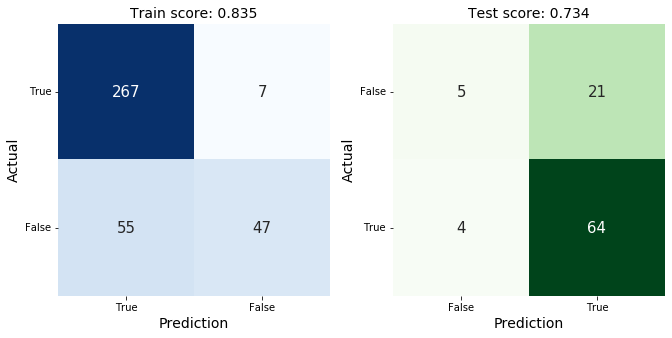

In [14]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [15]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

       False       0.87      0.46      0.60       102
        True       0.83      0.97      0.90       274

    accuracy                           0.84       376
   macro avg       0.85      0.72      0.75       376
weighted avg       0.84      0.84      0.82       376


Test report
              precision    recall  f1-score   support

       False       0.56      0.19      0.29        26
        True       0.75      0.94      0.84        68

    accuracy                           0.73        94
   macro avg       0.65      0.57      0.56        94
weighted avg       0.70      0.73      0.68        94



### Encoding with FastText

In [16]:
from gensim.models import FastText

In [26]:
fastText = FastText.load("model/fasttext/amalsholeh_review.fasttext").wv

In [27]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, fastText, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [28]:
vecs.shape

(470, 200)

### Dataset Splitting

In [29]:
X = vecs
y = df.PE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((376, 200), (94, 200), (376,), (94,))

### Training with SVM

In [30]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s


{'algo__C': 100.0, 'algo__gamma': 0.01}
0.8324468085106383 0.7926137566137567 0.7446808510638298


[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    9.4s finished


### Evaluation

In [31]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

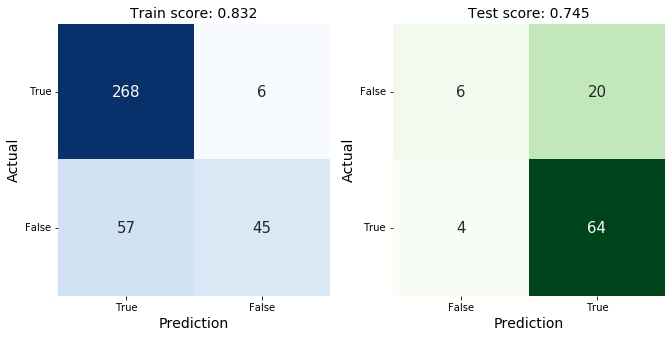

In [32]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [33]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

       False       0.88      0.44      0.59       102
        True       0.82      0.98      0.89       274

    accuracy                           0.83       376
   macro avg       0.85      0.71      0.74       376
weighted avg       0.84      0.83      0.81       376


Test report
              precision    recall  f1-score   support

       False       0.60      0.23      0.33        26
        True       0.76      0.94      0.84        68

    accuracy                           0.74        94
   macro avg       0.68      0.59      0.59        94
weighted avg       0.72      0.74      0.70        94

